In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

Reading Both Files as Dataframes

In [2]:
df=pd.read_csv('FinalData1.csv')
df2=pd.read_excel('British Airline  scrapped data 2019-2021.xlsx')

In [3]:
df2['Date Flown']=df2['Date Flown'].astype(str)

Concatinating the second data frame with First

In [4]:
df=pd.concat([df, df2],axis=0)

In [5]:
df.shape

(3886, 17)

Checking for Null Values in Our Dataset

In [5]:
df.isnull().sum()

Type Of Traveller          770
Seat Type                    2
Route                      774
Date Flown                 778
Seat Comfort               136
Cabin Staff Service        146
Food & Beverages           434
Inflight Entertainment    1229
Ground Service             865
Value For Money              0
Recommended                  0
Wifi & Connectivity       3280
Aircraft                  1836
reviews                      0
month                      778
year                       778
month_year                   0
dtype: int64

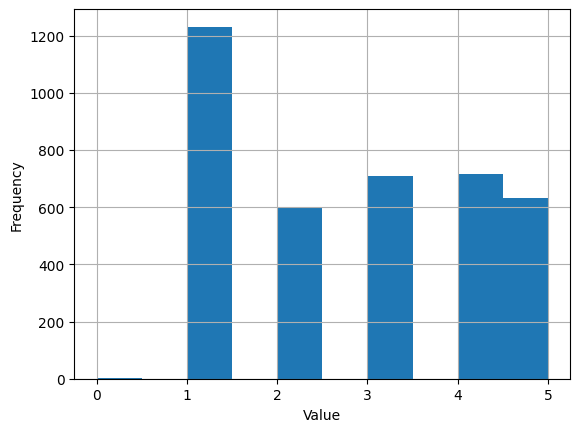

In [6]:
df['Value For Money'].hist()

# Set the x and y labels
plt.xlabel('Value')
plt.ylabel('Frequency')
# Show the plot
plt.show()

The above histogram shows that there is imbalance between categories and also there is  0 which occurs only one time in the dataset, So we will remove it

In [7]:
df =df.drop(df[df['Value For Money'] == 0].index)

So Reduce the Imbalance of categories, we are converting 5 values into 3 e.g 1 and 2 are considered as Bad, so we will replace it with 0.
Like wise 3 is mediocre so we will replace it with 1 and 4,5 are best so we will replace them with 2

In [8]:
def convert_val(x):
    threshold = 3
    if x==threshold:
        return 1
    elif x> threshold:
        return 2
    else:
        return 0

In [9]:
features = ['Type Of Traveller', 'Seat Type', 'Route', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Recommended','Ground Service','Year','Month','Day']


# Create a new column for classification
df['Value For Money'] = df['Value For Money'].apply(convert_val)
target='Value For Money'

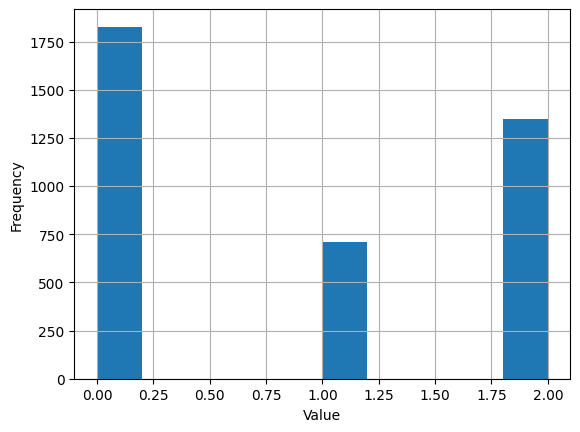

In [10]:
df['Value For Money'].hist()

# Set the x and y labels
plt.xlabel('Value')
plt.ylabel('Frequency')
# Show the plot
plt.show()

Now we have only one category that is imbalance, i-e 1
So we will see how we can deal it with using SMOTE

In [11]:
df['Recommended']=df['Recommended'].apply(lambda x: 1 if x=='yes' else 0)
# Replace missing values in 'Type Of Traveller' and 'Route' columns with the mode value
df['Type Of Traveller'].fillna(df['Type Of Traveller'].mode()[0], inplace=True)
df['Route'].fillna(df['Route'].mode()[0], inplace=True)
df['Date Flown'].dropna(inplace=True)
# Drop rows with missing values in 'Seat Type', 'Date Flown', 'month', and 'year' columns
df.dropna(subset=['Seat Type', 'Date Flown', 'month', 'year'], inplace=True)

# Replace missing values in other columns with the mean value
df['Seat Comfort'].fillna(df['Seat Comfort'].mean(), inplace=True)
df['Cabin Staff Service'].fillna(df['Cabin Staff Service'].mean(), inplace=True)
df['Food & Beverages'].fillna(df['Food & Beverages'].mean(), inplace=True)
df['Inflight Entertainment'].fillna(df['Inflight Entertainment'].mean(), inplace=True)
df['Ground Service'].fillna(df['Ground Service'].mean(), inplace=True)

# Drop 'Wifi & Connectivity' and 'Aircraft' columns due to a large number of missing values
df.drop(['Wifi & Connectivity', 'Aircraft'], axis=1, inplace=True)

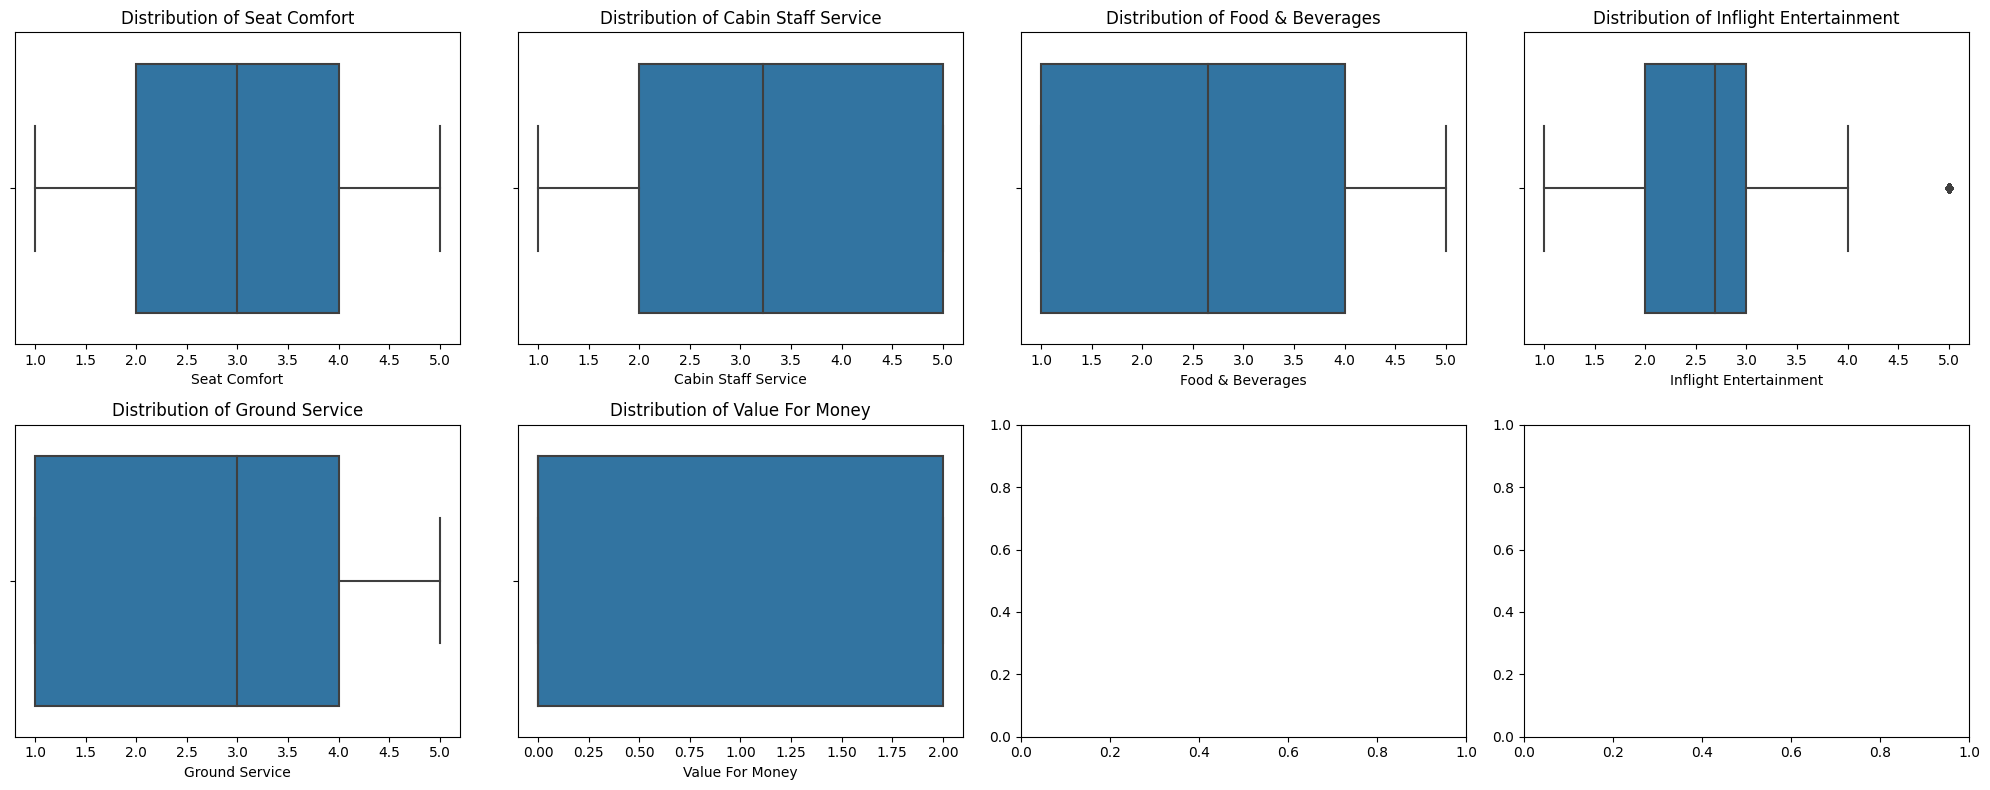

In [12]:
numerical_columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Value For Money']
# Create a boxplots figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Loop through each numerical column and create a boxplot to visualize the distribution of the data
for i, column in enumerate(numerical_columns):
    if i < 4:
        sns.boxplot(x=df[column], ax=axs[0][i])
        axs[0][i].set_title(f'Distribution of {column}')
    else:
        sns.boxplot(x=df[column], ax=axs[1][i-4])
        axs[1][i-4].set_title(f'Distribution of {column}')

# Show the plot
plt.tight_layout()
plt.show()

Removing Outliers from Inflight Entertainment

In [13]:
def remove_outliers(column):
    # Calculate the first and third quartiles of the column
    q1, q3 = np.percentile(column, [25, 75]).tolist()
    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Calculate the upper and lower bounds for outliers
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    # Remove values that are outside the bounds
    column = column[(column > lower_bound) & (column < upper_bound)]
    return column

In [14]:
df['Inflight Entertainment'] = remove_outliers(df['Inflight Entertainment']).reset_index(drop=True)
df.dropna(inplace=True)
df['Inflight Entertainment']=df['Inflight Entertainment'].round(2)

In [15]:
# Convert categorical variables into numerical form
le = LabelEncoder()
df['Type Of Traveller'] = le.fit_transform(df['Type Of Traveller'].astype(str))
df['Seat Type'] = le.fit_transform(df['Seat Type'].astype(str))
df['Route'] = le.fit_transform(df['Route'].astype(str))
df['Date Flown'] = df['Date Flown'].str.replace(' 00:00:00', '')

df['Date Flown'] = pd.to_datetime(df['Date Flown'])

# You can now access the individual components of the date (year, month, day, etc.) using dt accessor
df['Year'] = df['Date Flown'].dt.year
df['Month'] = df['Date Flown'].dt.month
df['Day'] = df['Date Flown'].dt.day

# Convert categorical variables into numerical form
le = LabelEncoder()
df['Type Of Traveller'] = le.fit_transform(df['Type Of Traveller'].astype(str))
df['Seat Type'] = le.fit_transform(df['Seat Type'].astype(str))
df['Route'] = le.fit_transform(df['Route'].astype(str))


In [16]:
from imblearn.over_sampling import SMOTE
X = df[features]
y = df[target]
smote = SMOTE(random_state=42)

# Fit and transform the data
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

In [17]:
X.isnull().sum()

Type Of Traveller         0
Seat Type                 0
Route                     0
Seat Comfort              0
Cabin Staff Service       0
Food & Beverages          0
Inflight Entertainment    0
Recommended               0
Ground Service            0
Year                      0
Month                     0
Day                       0
dtype: int64

In [18]:
df[df['Value For Money']==1].shape

(560, 18)

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [20]:
clf = GradientBoostingClassifier(max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', round(accuracy,3))
print(classification_report(y_test, y_pred))

Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       494
           1       0.83      0.80      0.82       464
           2       0.89      0.92      0.91       475

    accuracy                           0.87      1433
   macro avg       0.87      0.87      0.87      1433
weighted avg       0.87      0.87      0.87      1433



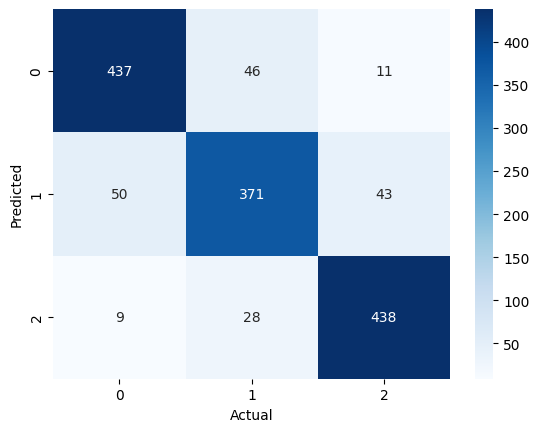

In [21]:
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [23]:
cm

array([[437,  46,  11],
       [ 50, 371,  43],
       [  9,  28, 438]], dtype=int64)

Below is the code to get feature importance from a GradientBoostingClassifier model

In [22]:
importances = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_})

# Sort values by importance
importances = importances.sort_values('importance', ascending=False)

# Print top 10 features
print(importances)

                   feature  importance
7              Recommended    0.312103
8           Ground Service    0.124651
2                    Route    0.118779
4      Cabin Staff Service    0.093879
3             Seat Comfort    0.092606
5         Food & Beverages    0.082366
10                   Month    0.043792
9                     Year    0.040614
6   Inflight Entertainment    0.039962
0        Type Of Traveller    0.027323
1                Seat Type    0.023924
11                     Day    0.000000
